# TODO:
- check interpolation was right for all Eckert reprojections (especially biomes)

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import palettable as ptb
import dask
import os, re

/home/deth/.local/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [6]:
debug = False
#hmap_cmap = ptb.scientific.sequential.Davos_20_r.mpl_colormap
#hmap_cmap = ptb.cartocolors.sequential.Mint_7.mpl_colormap
hmap_cmap = 'Greens'
lines_cmap = 'gist_heat_r'
chunks = (1, 1000, 1000)
masked = True
data_dir = '/media/deth/SLAB/TNC/AFC_albedo_data/biomes_raster/'
files = [os.path.join(data_dir, 'NetClimateImpactmedian005_ECKERTIV.tif'),
         os.path.join(data_dir, './ReforestationAlbedoRadiativeForcingmedian_ECKERTIV.tif'),
        ]
biome_file = os.path.join(data_dir,
            'Ecoregions2017_BIOME_DISSOLVE_BIOME_NUM_ECKERTIV.tif')

In [7]:
# read in the net-forcing and albedo-forcing maps
net, alb = [rxr.open_rasterio(f,
                              chunks=chunks,
                              masked=masked,
                             )[0] for f in files]

In [8]:
# back-calculate the non-albedo (i.e., agb-emissions) map
emis = net - alb

In [9]:
# read rasterized Dinerstein biomes
biomes = rxr.open_rasterio(biome_file,
                           chunks=chunks,
                           masked=True,
                          )[0]
assert biomes.rio.crs == alb.rio.crs
assert biomes.rio.resolution() == alb.rio.resolution()
assert np.all(biomes.rio.bounds() == alb.rio.bounds())

In [10]:
if debug:
    # plot to make sure things look right
    fig = plt.figure(figsize=(13,12))
    axnum = 1
    for var, lyr in zip(['alb', 'emis', 'net'],
                        [alb, emis, net]):
        ax = fig.add_subplot(2,2,axnum)
        lyr[17000:20000, 21000:24000].plot.imshow(ax=ax)
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title(var, fontdict={'fontsize': 15})
        axnum += 1

In [11]:
def get_2d_hist_from_lyrs(lyr_x, lyr_y, lyr_x_name, lyr_y_name,
                          xmin, xmax, ymin, ymax,
                          nbins=30,
                          subset_biome=None,
                          debug=debug,
                         ):
    """
    Calculate the 2d histogram for the 2xixj input stack,
    using xmin/max and ymin/max as the min and max values within which to create
    nbins bins.
    If subset_poly is not None then use it to only count stack pixels
    that fall within its polygon.
    """
    if subset_biome is not None:
        lyrs = [lyr.where(biomes==subset_biome,
                                  np.nan) for lyr in [lyr_x, lyr_y]]
    else:
        lyrs = [lyr_x, lyr_y]
    lyr_names = [lyr_x_name, lyr_y_name]
    stack = dask.array.stack(xr.concat(lyrs,
                                       dim=pd.Index(lyr_names, name='lyr')))
    stack = stack.rechunk(chunks=(stack.shape[0]-1,
                                  *chunks[1:]))
    if debug:
        stack = stack[:, 17000:20000, 21000:24000]
    stack
    assert stack.shape[0] == 2

    # compute a 2d histogram of the stacked emissions and albedo-forcing maps
    hist_da, xedge_da, yedge_da = dask.array.histogram2d(stack[0].ravel(),
                                                         stack[1].ravel(),
                                                         bins=nbins,
                                                         range=((xmin, xmax), (ymin, ymax)),
                                                        )
    # compute it
    hist = hist_da.compute()
    xedge = xedge_da.compute()
    yedge = yedge_da.compute()
    
    return hist, xedge, yedge

In [13]:
def draw_cmap_hex_color(cmap, val, min_val, max_val,
                        low_cmap_frac=0,
                        high_cmap_frac=1,
                       ):
    """
    draw, from the given cmap, truncated to the fraction of its total color range
    defined by [low_cmap_frac, high_cmap_frac], and linearly interpolated
    between min_val and max_val, the hexadecimal color corresponding to val
    """
    cmap_obj = plt.cm.get_cmap(cmap)
    norm_val = (val - min_val)/(max_val - min_val)
    low_cmap_256 = low_cmap_frac*255
    high_cmap_256 = high_cmap_frac*255
    norm_val_256 = int(low_cmap_256 + (norm_val * (high_cmap_256 - low_cmap_256)))
    rgba_color = cmap_obj(norm_val_256)
    hex_color = mpl.colors.rgb2hex(rgba_color)
    return hex_color

In [28]:
def plot_2d_hist_heatmap(hist2d, xedge, yedge, xlabel, ylabel, ax,
                         hmap_cmap = hmap_cmap,
                         lines_cmap = lines_cmap,
                         vmin=None, vmax=None,
                        ):
    """
    Plot a heatmap of the given hist2d object,
    into the Axes object given as ax,
    calculating the axis extents from xedge and yedge.
    Colormaps for heatmap and percent offset lines can
    be tweaked, as well as other formatting deatils.
    """
    extent = [xedge[0], xedge[-1], yedge[0], yedge[-1]]
    img = ax.imshow(hist2d,
                    extent=extent,
                    origin='lower',
                    cmap=hmap_cmap,
                    vmin=vmin,
                    vmax=vmax,
                   )
    cbar = plt.colorbar(img)
    cbar.set_label('pixel count (millions)',
                   fontdict={'fontsize': 14},
                  )
    cbar.ax.tick_params(labelsize=12)

    # add offset lines
    pcts = [25, 50, 100]
    for offset_pct in pcts:
        x = []
        y = []
        for alb_val in range(int(ax.get_ylim()[0]), 0):
            emis_val = -1 * alb_val/(offset_pct/100)
            x.append(emis_val)
            y.append(alb_val)
        ax.plot(x,
                y,
                color=draw_cmap_hex_color(lines_cmap,
                                          offset_pct,
                                          min_val=np.min(pcts),
                                          max_val=np.max(pcts),
                                          low_cmap_frac=0.2,
                                          high_cmap_frac=1.0,
                                         ),
                linewidth=2,
                alpha=0.75,
                label=f'{offset_pct}%',
               )

    # format the plot
    lgd = ax.legend(#loc='upper center',
                    bbox_to_anchor=(1.3, 0, 0.4, 0.2),
                    fontsize='large',
                    title='% offset',
                   )
    lgd.set_label('% offset',
                 )
    ax.set_xlim(extent[:2])
    ax.set_ylim(extent[2:])
    ax.set_aspect('auto')
    ax.set_xlabel(xlabel,
                  fontdict={'fontsize': 18})
    ax.set_ylabel(ylabel,
                  fontdict={'fontsize': 18})  
    ax.tick_params(labelsize=14)

In [15]:
# set min and max values for both heatmap axes
xmin, xmax = [0, 1000]
ymin, ymax = [-850, 150]

In [16]:
# check that the histogram sums to the number of non-nan cells in the dataset
if debug:
    assert np.product(stack.shape[1:]) - np.sum(np.max(np.isnan(stack), axis=0)).compute() == np.sum(hist)
    print('HISTOGRAM SUM IS CORRECT')

In [17]:
ax_labels = {'emis': 'emissions from AGB\n($Mg\ CO_{2}\ ha^{-1}$)',
             'alb': 'albedo-driven radiative forcing\n($Mg\ CO_{2}e\ ha^{-1}$)',
            }

In [19]:
# load global biomes shapefile
# (dissolved from the Dinerstein ecoregions)
biome_df = pd.DataFrame(gpd.read_file(
    os.path.join(data_dir,'Ecoregions2017_BIOME_DISSOLVE.shp')).loc[:, ['BIOME_NUM', 'BIOME_NAME']])
biome_df

,BIOME_NUM,BIOME_NAME
0,0,Tropical & Subtropical Moist Broadleaf Forests
1,1,Tropical & Subtropical Dry Broadleaf Forests
2,2,Tropical & Subtropical Coniferous Forests
3,3,Temperate Broadleaf & Mixed Forests
4,4,Temperate Conifer Forests
5,5,Boreal Forests/Taiga
6,6,"Tropical & Subtropical Grasslands, Savannas & ..."
7,7,"Temperate Grasslands, Savannas & Shrublands"
8,8,Flooded Grasslands & Savannas
9,9,Montane Grasslands & Shrublands


In [25]:
biome_ids = [None, 5, 6, 0]

results = {}

for i, biome_id in enumerate(biome_ids):
    print(f'\n\nNOW PROCCESSING BIOME ID: {biome_id}...\n\n')
    hist2d_biome, xedge_biome, yedge_biome = get_2d_hist_from_lyrs(emis, alb, 'emis', 'alb',
                                                                   xmin, xmax, ymin, ymax,
                                                                   subset_biome=biome_id,
                                                                   debug=debug,
                                                                  )
    results[biome_id] = (hist2d_biome, xedge_biome, yedge_biome)



NOW PROCCESSING BIOME ID: None...




NOW PROCCESSING BIOME ID: 5...




NOW PROCCESSING BIOME ID: 6...




NOW PROCCESSING BIOME ID: 0...




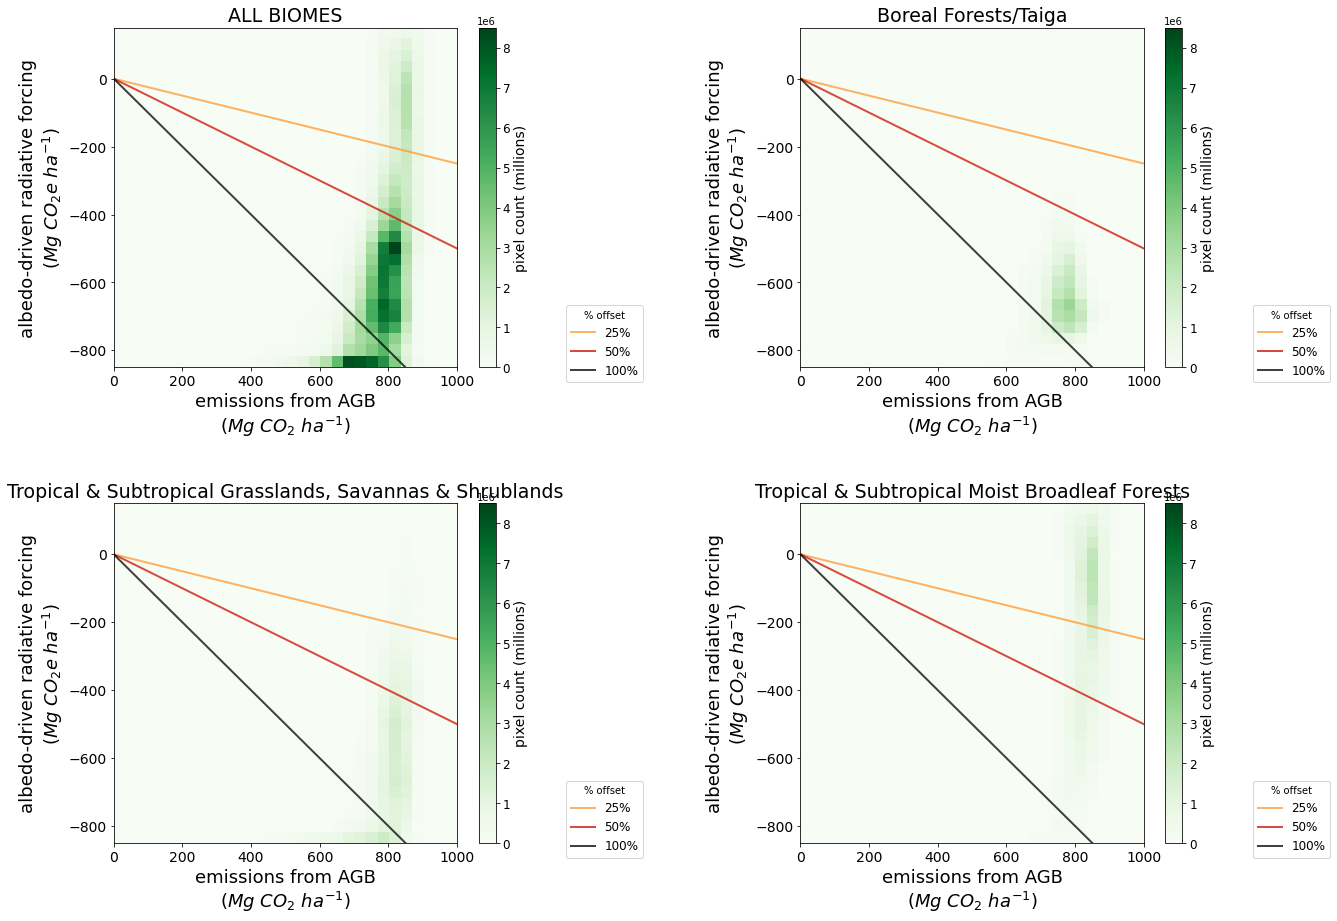

In [30]:
fig = plt.figure(figsize=(int(5*len(biome_ids)),int(7.5*(len(biome_ids)/2))))
for i, biome_id in enumerate(biome_ids):
    ax_biome = fig.add_subplot(2, int(len(biome_ids)/2), i+1)
    hist2d_biome, xedge_biome, yedge_biome = results[biome_id]
    plot_2d_hist_heatmap(hist2d_biome,
                         xedge_biome,
                         yedge_biome,
                         ax_labels['emis'],
                         ax_labels['alb'],
                         ax_biome,
                         vmin=0,
                         vmax=8.5e6
                        )
    if biome_id is None:
        ax_title = 'ALL BIOMES'
    else:
        ax_title = biome_df['BIOME_NAME'][biome_id]
    ax_biome.set_title(ax_title, fontdict={'fontsize': 19})
fig.subplots_adjust(hspace=0.4,
                    wspace=0.6)

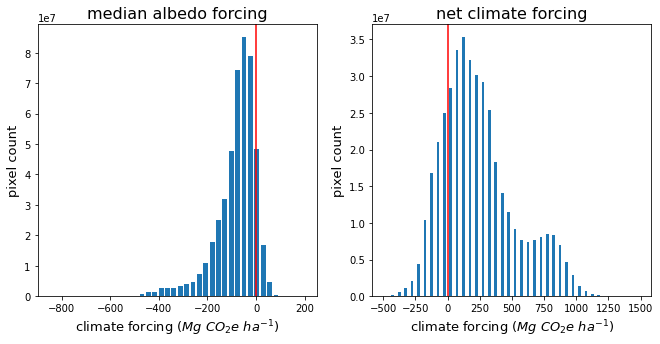